In [40]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [41]:
# Load and sort the data
df = pd.read_csv('first_25000_rows.csv')
df['ts_event'] = pd.to_datetime(df['ts_event'], utc=True)
# df = df.sort_values(['ts_event', 'sequence'], ignore_index=True)(uncomment if not in sequence)


In [42]:
start_time = df['ts_event'].min()
end_time   = df['ts_event'].max()
# Compute the total duration
total_duration = end_time - start_time

# Print results
print(f"Earliest event: {start_time}")
print(f"Latest event:   {end_time}")
print(f"Total time span: {total_duration}\n")

print(f'The Dataset contains 5000 observations of orderbook orders of apple\n stock trading from {start_time} to {end_time} for a total duration of {total_duration}')

Earliest event: 2024-10-21 11:54:29.221064336+00:00
Latest event:   2024-10-21 13:04:20.130842270+00:00
Total time span: 0 days 01:09:50.909777934

The Dataset contains 5000 observations of orderbook orders of apple
 stock trading from 2024-10-21 11:54:29.221064336+00:00 to 2024-10-21 13:04:20.130842270+00:00 for a total duration of 0 days 01:09:50.909777934


In [43]:
# Define levels 0–9
levels = range(10)

define the number of levels present in the dataset

In [44]:
# Per-event OFI delta for each level m
for m in levels:
    bid_px = f'bid_px_{m:02d}'
    bid_sz = f'bid_sz_{m:02d}'
    ask_px = f'ask_px_{m:02d}'
    ask_sz = f'ask_sz_{m:02d}'

    # Compute bid-side flow
    prev_bp = df[bid_px].shift(1)
    prev_bs = df[bid_sz].shift(1)
    df[f'OF_b_{m}'] = np.where(
        df[bid_px] > prev_bp, df[bid_sz],
        np.where(
            df[bid_px] < prev_bp, -prev_bs,
            df[bid_sz] - prev_bs
        )
    )

    # Compute ask-side flow
    prev_ap = df[ask_px].shift(1)
    prev_as = df[ask_sz].shift(1)
    df[f'OF_a_{m}'] = np.where(
        df[ask_px] < prev_ap, df[ask_sz],
        np.where(
            df[ask_px] > prev_ap, -prev_as,
            df[ask_sz] - prev_as
        )
    )

    # Event-level OFI
    df[f'delta_OFI_{m}'] = df[f'OF_b_{m}'] - df[f'OF_a_{m}']
    df[f'delta_OFI_{m}'] = df[f'delta_OFI_{m}'].fillna(0)

iterates over the 10 LOB levels (0–9) to compute the per-event OFI $$
\delta \text{OFI}_{i,n}^m = \text{OF}_{i,n}^{m,b} - \text{OF}_{i,n}^{m,a}
$$ each level m. OFI measures the net order flow pressure by comparing bid-side and ask-side order flows, based on changes in LOB prices and sizes

In [45]:
# Bucket into 1-minute intervals
df['time_bucket'] = df['ts_event'].dt.floor('1min')

# Sum per-minute OFI by level
ofi_cols = []
for m in levels:
    col = f'delta_OFI_{m}'
    ofi = df.groupby('time_bucket')[col].sum().rename(f'ofi_level_{m}')
    ofi_cols.append(f'ofi_level_{m}')
    if m == 0:
        best_ofi = ofi
    # Collect into DataFrame
    if m == 0:
        ofi_df = ofi.to_frame()
    else:
        ofi_df = ofi_df.join(ofi)

# Compute multi-level OFI = sum of ofi_level_0…ofi_level_9
ofi_df['multi_level_ofi'] = ofi_df[[f'ofi_level_{m}' for m in range(10)]].sum(axis=1)

# Best-level OFI
ofi_df['best_level_ofi'] = ofi_df['ofi_level_0']


aggregates per-event Order Flow Imbalance (OFI) data into 1-minute intervals and computes two key OFI features: Best-Level OFI and Multi-Level OFI. It processes the AAPL dataset’s per-event OFI values  for each of the 10 LOB levels, previously stored in columns delta_OFI_{m}

In [46]:
# PCA-based Integrated OFI
# Prepare the 10-level OFI matrix
X = ofi_df[[f'ofi_level_{m}' for m in levels]].values

# Standardize for PCA weight estimation
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# Fit PCA and take PC1 weights
pca = PCA(n_components=1, svd_solver='full', random_state=0)
pc1 = pca.fit(Xs).components_[0]

# Normalize weights by L1 norm
w = pc1 / np.sum(np.abs(pc1))

# Compute integrated OFI as weighted sum of raw OFI values
ofi_df['integrated_ofi'] = np.dot(X, w)

calculates the Integrated Order Flow Imbalance  for the AAPL dataset using Principal Component Analysis. It processes the aggregated 1-minute OFI values for each of the 10 levels to create a single, PCA-weighted OFI metric that captures the primary variance across all levels.

# Cross Asset OFI
As the Dataset provided in the Googledrive link only contains a single asset data i will explain how cross asset ofi works here.

The **cross-asset impact** of one asset’s Order Flow Imbalance (OFI) on the price movements or returns of another asset  within a multi-asset framework. It investigates how OFI features **Best-Level OFI**, **Multi-Level OFI**, and **Integrated OFI** derived from an asset’s limit order book  influence the returns of other assets.According to the paper
After Computing OFI values (Best,MultiLevel,Integrated) for both assets for example AAPL and MSFT ,create and align the ofi features of both assets in the 1 minute interval and the 1 min return of the asset you want(MSFT here) to measure the impact and fit a LASSO regression model to calculate MSFT return at time t+1 using lagged OFI values (at time t).To analyze the cross-asset impact of AAPL’s Order Flow Imbalance (OFI) on MSFT’s returns, LASSO regression is used to estimate coefficients $\beta_{\text{AAPL}}, \beta_{\text{MSFT}}$ that quantify how AAPL’s OFI at time \( t \) influences MSFT’s returns at time \( t+1 \).


In [47]:
# Export results
results = ofi_df.reset_index()[['time_bucket', 'best_level_ofi', 'multi_level_ofi', 'integrated_ofi']]
results.rename(columns={'time_bucket': 'timestamp'}, inplace=True)
results.to_csv('ofi_results.csv', index=False)
print(results)

                   timestamp  best_level_ofi  multi_level_ofi  integrated_ofi
0  2024-10-21 11:54:00+00:00          -195.0           1438.0      138.017774
1  2024-10-21 11:55:00+00:00          -916.0           1089.0       57.151152
2  2024-10-21 11:56:00+00:00           199.0           1396.0      119.651434
3  2024-10-21 11:57:00+00:00           201.0           -632.0      -83.584743
4  2024-10-21 11:58:00+00:00           863.0           3550.0      313.745877
..                       ...             ...              ...             ...
66 2024-10-21 13:00:00+00:00          -989.0          -1887.0     -224.288183
67 2024-10-21 13:01:00+00:00         -1122.0          -6024.0     -558.007761
68 2024-10-21 13:02:00+00:00         -4344.0         -24516.0    -2330.781831
69 2024-10-21 13:03:00+00:00           181.0           5674.0      604.831872
70 2024-10-21 13:04:00+00:00          -219.0          -5073.0     -486.114420

[71 rows x 4 columns]


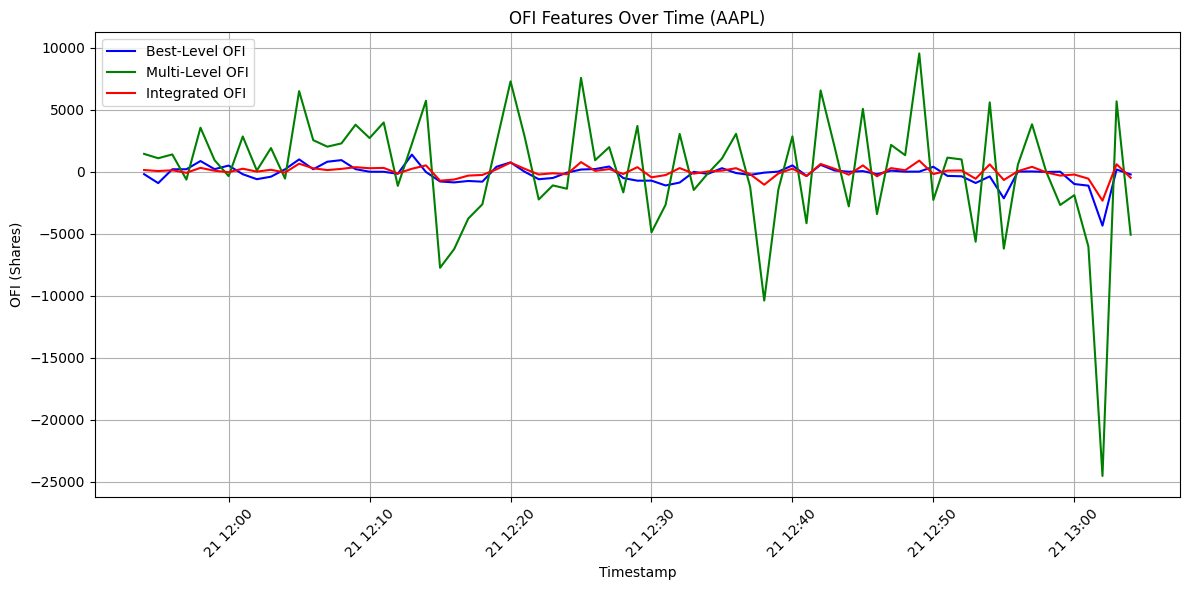

In [48]:
# Visualizations
# 1. Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(results['timestamp'], results['best_level_ofi'], label='Best-Level OFI', color='blue')
plt.plot(results['timestamp'], results['multi_level_ofi'], label='Multi-Level OFI', color='green')
plt.plot(results['timestamp'], results['integrated_ofi'], label='Integrated OFI', color='red')
plt.xlabel('Timestamp')
plt.ylabel('OFI (Shares)')
plt.title('OFI Features Over Time (AAPL)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('ofi_timeseries.png')
plt.show()



